In [25]:
pip install pandas numpy matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns

In [27]:
# Load the data
data = pd.read_csv('./housing/housing.csv')

#Examine the data
print(data.head())
print(data.info())
print(data.describe())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880           129.0   
1    -122.22     37.86                  21         7099          1106.0   
2    -122.24     37.85                  52         1467           190.0   
3    -122.25     37.85                  52         1274           235.0   
4    -122.25     37.85                  52         1627           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0         322         126         8.3252              452600        NEAR BAY  
1        2401        1138         8.3014              358500        NEAR BAY  
2         496         177         7.2574              352100        NEAR BAY  
3         558         219         5.6431              341300        NEAR BAY  
4         565         259         3.8462              342200        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [28]:
#  Handle missing values
# Impute missing values in total_bedrooms
imputer = SimpleImputer(strategy='median')
# Select only numeric columns for imputation
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                   'total_bedrooms', 'population', 'households', 'median_income', 
                   'median_house_value']
data_numeric = data[numeric_features].copy()
# Apply imputation
data_numeric_imputed = pd.DataFrame(
    imputer.fit_transform(data_numeric),
    columns=data_numeric.columns,
    index=data_numeric.index
)

In [29]:
# Feature engineering
# Create additional features that might be useful
data_numeric_imputed['rooms_per_household'] = data_numeric_imputed['total_rooms'] / data_numeric_imputed['households']
data_numeric_imputed['bedrooms_per_room'] = data_numeric_imputed['total_bedrooms'] / data_numeric_imputed['total_rooms']
data_numeric_imputed['population_per_household'] = data_numeric_imputed['population'] / data_numeric_imputed['households']


In [30]:
# Feature scaling
# Scale the features to have mean=0 and variance=1
scaler = StandardScaler()
# Exclude median_house_value from clustering but keep it for analysis
features_for_clustering = [col for col in data_numeric_imputed.columns if col != 'median_house_value']
data_scaled = scaler.fit_transform(data_numeric_imputed[features_for_clustering])

In [31]:
#  Apply K-means algorithm with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster labels to the original data
data['cluster'] = clusters

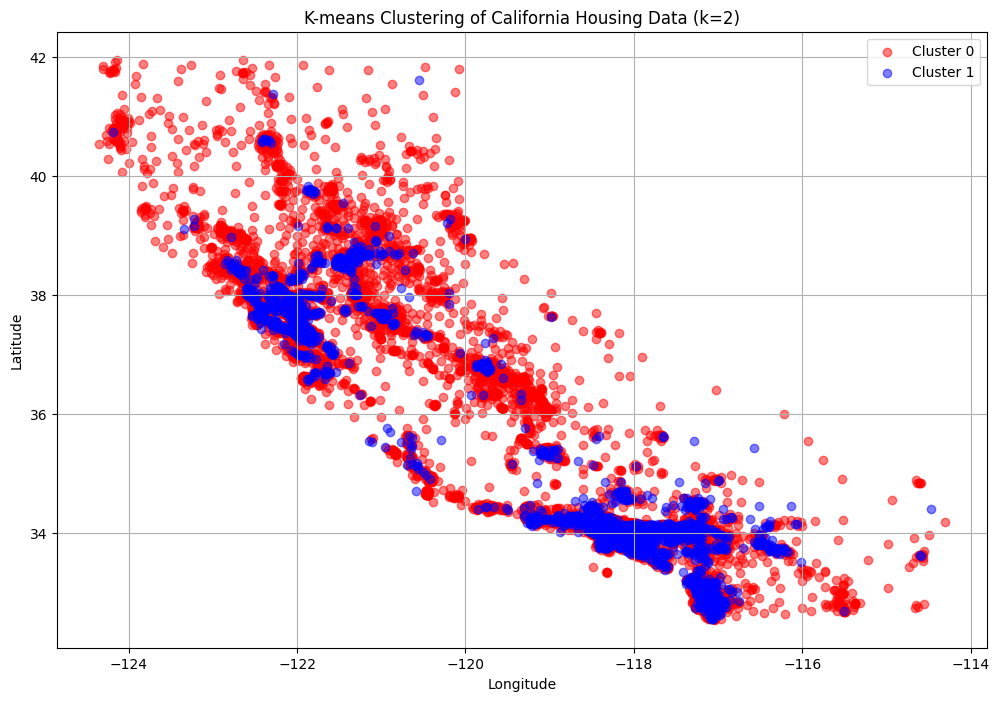

In [32]:
#  Visualize the clusters on a scatter plot of longitude vs latitude
plt.figure(figsize=(12, 8))
plt.scatter(data[data['cluster'] == 0]['longitude'], 
            data[data['cluster'] == 0]['latitude'], 
            c='red', label='Cluster 0', alpha=0.5)
plt.scatter(data[data['cluster'] == 1]['longitude'], 
            data[data['cluster'] == 1]['latitude'], 
            c='blue', label='Cluster 1', alpha=0.5)
plt.title('K-means Clustering of California Housing Data (k=2)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('kmeans_clusters_map.png')  # Save the figure
plt.show()


Cluster Statistics:
         median_house_value  median_income  housing_median_age
cluster                                                       
0             204953.123725       3.833651           30.098113
1             221275.479219       4.151231           17.585204


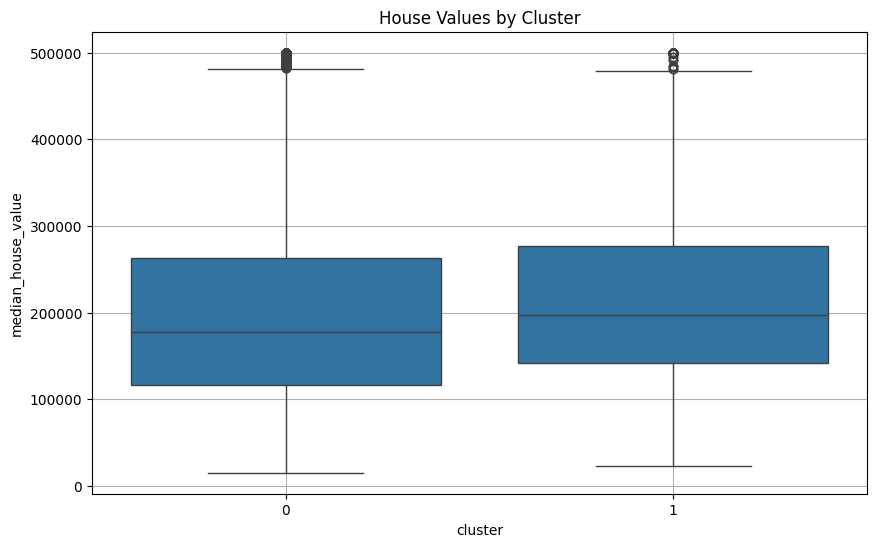

In [ ]:
#  Analyze the clusters
numeric_columns = data.select_dtypes(include=['number']).columns
cluster_stats = data.groupby('cluster')[numeric_columns].mean()
print("Cluster Statistics:")
print(cluster_stats[['median_house_value', 'median_income', 'housing_median_age']])

# Compare house values between clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='median_house_value', data=data)
plt.title('House Values by Cluster')
plt.grid(True)
plt.savefig('house_values_by_cluster.png')  # Save the figure
plt.show()

In [ ]:
# Analyze feature importance for clustering
# Calculate the cluster centers in the original feature space
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features_for_clustering
)
print("\nCluster Centers (Original Scale):")
print(cluster_centers)

# Evaluate clustering performance
# Calculate silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data_scaled, clusters)
print(f"\nSilhouette Score: {silhouette_avg}")


Cluster Centers (Original Scale):
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.619909  35.681411           30.101569  2079.902491      425.692823   
1 -119.191006  35.258108           17.610927  6828.645281     1375.218543   

    population   households  median_income  rooms_per_household  \
0  1147.554159   398.145413       3.833612             5.417053   
1  3521.859685  1264.361341       4.150206             5.519117   

   bedrooms_per_room  population_per_household  
0           0.213800                  3.099994  
1           0.213746                  2.849351  

Silhouette Score: 0.3882863345285948


In [ ]:
# Try different values of k to find optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters_k = kmeans_k.fit_predict(data_scaled)
    inertia.append(kmeans_k.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, clusters_k))


# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.grid(True)
plt.tight_layout()
plt.savefig('kmeans_optimization.png')  # Save the figure
plt.show()